In [519]:
import pandas as pd
from yelpapi import YelpAPI
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation

import time

%matplotlib inline

ISSDTTM and EXPDTTM,which stand for “issued date and time” and “expired date and time”

In [494]:
key_data=pd.read_csv('keys.csv', header=None)
key_data = key_data.set_index(0).transpose()



In [527]:
#This takes about a minute to run because it needs to parse the dates.
temp = pd.read_csv('Food_Establishment_Inspections.csv', low_memory=False,parse_dates=[12], infer_datetime_format=True)

In [496]:
data = temp
data.rename(columns = {'RESULTDTTM':'Date'}, inplace=True)
features = ['BusinessName', 'LegalOwner', 'ViolLevel', 'RESULT', 'Zip', 'Date', 'Address', 'City']

data=data[features]
data.loc[:,'ViolLevel'] = data['ViolLevel'].map({'*': 1, '**': 2, '***':3})

#Remove locations with date error
data = data[(data.RESULT != 'DATAERR') & (data.RESULT != 'HE_OutBus') & (data.RESULT != 'HE_NotReq') & 
            (data.RESULT != 'HE_Misc') & (data.RESULT != 'HE_TSOP')]

data.loc[:,'RESULT'] = data['RESULT'].map({'HE_Closure': 0,'HE_Fail':0,
                    'Fail':0, 'Failed':0, 'HE_FAILNOR':0,
                    'HE_FailExt':0, 'HE_Filed':0,
                    'HE_Hearing':0,'HE_Hold':0,
                    'HE_Pass':1, 'Pass':1})
data.shape

(335946, 8)

In [497]:
data=data.join(pd.get_dummies(data.ViolLevel).iloc[:,:3])

grouped=data.groupby(['BusinessName', 'Address', 'Date'])

clean_data = grouped.sum()
clean_data.head()


ViolLevel  \
BusinessName              Address              Date                             
1000 Washington Cafe      1000   Washington ST 2010-03-18 10:05:34        NaN   
                                               2010-07-26 10:05:35          6   
                                               2010-08-04 10:11:58          6   
                                               2011-02-09 11:05:14          2   
125 Nashua St. Cafe (MGH) 125  Nashua St       2015-07-10 10:59:00        NaN   

                                                                    RESULT  \
BusinessName              Address              Date                          
1000 Washington Cafe      1000   Washington ST 2010-03-18 10:05:34       1   
                                               2010-07-26 10:05:35       0   
                                               2010-08-04 10:11:58       6   
                                               2011-02-09 11:05:14       0   
125 Nashua St. Cafe (MGH) 125  Nashua St       2015-07-10 10:59:00       1   

                                                                    1.0  2.0  \
BusinessName              Address              Date                            
1000 Washington Cafe      1000   Washington ST 2010-03-18 10:05:34    0    0   
                                               2010-07-26 10:05:35    6    0   
                                               2010-08-04 10:11:58    6    0   
                                               2011-02-09 11:05:14    2    0   
125 Nashua St. Cafe (MGH) 125  Nashua St       2015-07-10 10:59:00    0    0   

                                                                    3.0  
BusinessName              Address              Date                      
1000 Washington Cafe      1000   Washington ST 2010-03-18 10:05:34    0  
                                               2010-07-26 10:05:35    0  
                                               2010-08-04 10:11:58    0  
                                               2011-02-09 11:05:14    0  
125 Nashua St. Cafe (MGH) 125  Nashua St       2015-07-10 10:59:00    0

In [498]:
# grouped.first().Zip

long_clean = clean_data.reset_index()
long_clean['ID'] = long_clean['BusinessName'] +':' + long_clean['Address']

long_clean.head(5)

,BusinessName,Address,Date,ViolLevel,RESULT,1.0,2.0,3.0,ID
0,1000 Washington Cafe,1000 Washington ST,2010-03-18 10:05:34,NaN,1,0,0,0,1000 Washington Cafe:1000 Washington ST
1,1000 Washington Cafe,1000 Washington ST,2010-07-26 10:05:35,6,0,6,0,0,1000 Washington Cafe:1000 Washington ST
2,1000 Washington Cafe,1000 Washington ST,2010-08-04 10:11:58,6,6,6,0,0,1000 Washington Cafe:1000 Washington ST
3,1000 Washington Cafe,1000 Washington ST,2011-02-09 11:05:14,2,0,2,0,0,1000 Washington Cafe:1000 Washington ST
4,125 Nashua St. Cafe (MGH),125 Nashua St,2015-07-10 10:59:00,NaN,1,0,0,0,125 Nashua St. Cafe (MGH):125 Nashua St


In [499]:
# create number representing days passed since last inspection date and current inspection date. first entry for a restaurant is set at 0 delta
temp_df = long_clean[['ID', 'Date']]
temp_df.loc[:,'temp_date'] = temp_df['Date']
g = temp_df.groupby(['ID', 'Date'])
delta = g.temp_date.first().diff()

for i in delta.index.levels[0]:
    delta[i][0] = 0  # won't allow np.nan or pd.NaT directly

In [500]:
long_clean['Delta_t']=delta.values

long_clean['Zip'] = grouped.first().Zip.values
long_clean.loc[:,'Delta_t'] = long_clean.Delta_t.dt.days

long_clean=long_clean[~long_clean.Zip.isnull()]
long_clean.RESULT[long_clean.RESULT > 0] = 1

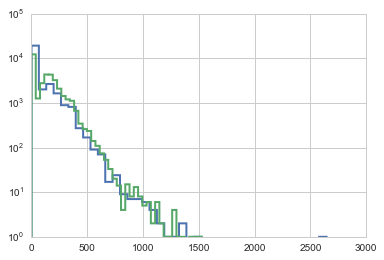

In [501]:
plt.hist(long_clean.Delta_t[long_clean.RESULT>0], 40, histtype='step', lw=2)
plt.hist(long_clean.Delta_t[long_clean.RESULT==0], 40, histtype='step', lw=2)
plt.gca().set_yscale("log")


In [502]:
long_clean[long_clean['BusinessName'].str.contains('Villa Francesca')]

,BusinessName,Address,Date,ViolLevel,RESULT,1.0,2.0,3.0,ID,Delta_t,Zip
61605,Villa Francesca,150 RICHMOND,2008-04-30 09:38:15,NaN,1,0,0,0,Villa Francesca:150 RICHMOND,0,02113
61606,Villa Francesca,150 RICHMOND,2008-10-01 12:34:35,1,0,1,0,0,Villa Francesca:150 RICHMOND,154,02113
61607,Villa Francesca,150 RICHMOND,2009-03-24 10:52:50,NaN,1,0,0,0,Villa Francesca:150 RICHMOND,173,02113
61608,Villa Francesca,150 RICHMOND,2009-10-01 11:29:51,2,0,2,0,0,Villa Francesca:150 RICHMOND,191,02113
61609,Villa Francesca,150 RICHMOND,2010-05-27 11:35:39,7,0,4,0,1,Villa Francesca:150 RICHMOND,238,02113
61610,Villa Francesca,150 RICHMOND,2010-06-03 12:29:47,7,1,4,0,1,Villa Francesca:150 RICHMOND,7,02113
61611,Villa Francesca,150 RICHMOND,2010-10-22 10:51:46,3,0,1,1,0,Villa Francesca:150 RICHMOND,140,02113
61612,Villa Francesca,150 RICHMOND,2010-11-05 11:00:02,3,1,1,1,0,Villa Francesca:150 RICHMOND,14,02113
61613,Villa Francesca,150 RICHMOND,2011-11-28 11:05:00,4,0,4,0,0,Villa Francesca:150 RICHMOND,388,02113
61614,Villa Francesca,150 RICHMOND,2011-12-05 10:39:49,4,1,4,0,0,Villa Francesca:150 RICHMOND,6,02113


In [ ]:
taco = long_clean[long_clean['BusinessName'].str.contains('TACO MEX')]
taco['Year'] =  taco.Date.dt.year
taco.RESULT[taco.RESULT > 0] = 1
# taco['Delta_t'] = (taco['Delta_t']/np.timedelta64(1,'D')).astype(int)

# plt.plot(taco.Date.values, taco.ViolLevel.values, 'bo')
# plt.plot(taco.Date[taco.RESULT>0], taco.Delta_t[taco.RESULT>0], '.', markersize=10, label="Pass")
# plt.plot(taco.Date[taco.RESULT==0], taco.Delta_t[taco.RESULT==0]+1, 'rs', markeredgewidth=1, markersize=5, label="Fail")
# plt.xlabel('Time since last inspection')
# plt.ylabel('Date of Inspection')
# plt.title('Taco Mex - History')
# plt.legend(frameon=True)
# plt.savefig('Taco_Mex.pdf')

<Container object of 2 artists>

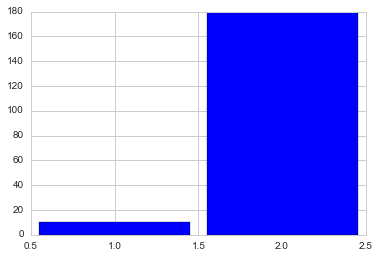

In [503]:
delta_pass=taco.Delta_t[taco.RESULT==1]
delta_fail=taco.Delta_t[taco.RESULT==0]

plt.bar([1, 2], [delta_pass.mean(), delta_fail.mean()] ,width=.9,color='b',align='center')
# plt.savefig('TacoMex.pdf')

In [504]:
delta_pass.mean(), delta_fail.mean()

(10.583333333333334, 179.59999999999999)

In [505]:
long_clean.RESULT.sum() / float(long_clean.RESULT.shape[0])

0.43650532323564922

In [439]:
long_clean['Result_last'] = long_clean.groupby(['ID'])['RESULT'].transform(lambda x:x.shift())
long_clean['Date_last'] = long_clean.groupby(['ID'])['Date'].transform(lambda x:x.shift())

long_clean['Result_last'][long_clean.Result_last.isnull()]=-1
long_clean['Date_last'][long_clean.Result_last.isnull()]=-1

long_clean['Day_of_week'] = long_clean.Date_last.dt.dayofweek
long_clean['Month'] = long_clean.Date_last.dt.month
long_clean['Year'] = long_clean.Date_last.dt.year
long_clean['Quarter'] = long_clean.Date_last.dt.quarter

/Users/damienrj/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/damienrj/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [401]:
long_clean = long_clean.join(pd.get_dummies(long_clean.Result_last, prefix='Old_Result').iloc[:, 1:3])

In [402]:
long_clean.head()

,BusinessName,Address,Date,ViolLevel,RESULT,1.0,2.0,3.0,ID,Delta_t,Zip,Result_last,Date_last,Day_of_week,Month,Year,Quarter,Old_Result_0.0,Old_Result_1.0
0,1000 Washington Cafe,1000 Washington ST,2010-03-18 10:05:34,NaN,1,0,0,0,1000 Washington Cafe:1000 Washington ST,0,02118,-1,NaT,NaN,NaN,NaN,NaN,0,0
1,1000 Washington Cafe,1000 Washington ST,2010-07-26 10:05:35,6,0,6,0,0,1000 Washington Cafe:1000 Washington ST,130,02118,1,2010-03-18 10:05:34,3,3,2010,1,0,1
2,1000 Washington Cafe,1000 Washington ST,2010-08-04 10:11:58,6,1,6,0,0,1000 Washington Cafe:1000 Washington ST,9,02118,0,2010-07-26 10:05:35,0,7,2010,3,1,0
3,1000 Washington Cafe,1000 Washington ST,2011-02-09 11:05:14,2,0,2,0,0,1000 Washington Cafe:1000 Washington ST,189,02118,1,2010-08-04 10:11:58,2,8,2010,3,0,1
4,125 Nashua St. Cafe (MGH),125 Nashua St,2015-07-10 10:59:00,NaN,1,0,0,0,125 Nashua St. Cafe (MGH):125 Nashua St,0,02114,-1,NaT,NaN,NaN,NaN,NaN,0,0


Boston appears to give the same violations with a passed status once the previous violations have been taken care of.

clean_data.groupby(level=0).sum().sort_values(3, ascending=False).head(5)

# Section for pulling data from yelp

In [14]:
keys = pd.read_csv('keys.csv', header=None)
keys.set_index(0, inplace=True)

keys=keys[1].to_dict()

In [14]:
resturants = long_clean.groupby('ID').last()
resturants.head()

names = resturants.BusinessName


In [30]:
yelp_api.search_query(term = '1000 Washington Cafe', location = resturants['Address'][0] + ',Boston, MA ' + resturants['Zip'][0], limit=13, sort = 1)

{u'businesses': [{u'categories': [[u'Farmers Market', u'farmersmarket']],
   u'distance': 428.18673095161074,
   u'id': u'south-end-open-market-boston-2',
   u'image_url': u'http://s3-media3.fl.yelpcdn.com/bphoto/x5-v0jkysjDLxGACqbWv9w/ms.jpg',
   u'is_claimed': True,
   u'is_closed': False,
   u'location': {u'address': [u'500 Harrison Ave'],
    u'city': u'Boston',
    u'coordinate': {u'latitude': 42.3420052975416,
     u'longitude': -71.0661041736603},
    u'country_code': u'US',
    u'cross_streets': u'Perry St & Randolph St',
    u'display_address': [u'500 Harrison Ave',
     u'South End',
     u'Boston, MA 02118'],
    u'geo_accuracy': 8.0,
    u'neighborhoods': [u'South End'],
    u'postal_code': u'02118',
    u'state_code': u'MA'},
   u'mobile_url': u'http://m.yelp.com/biz/south-end-open-market-boston-2?utm_campaign=yelp_api&utm_medium=api_v2_search&utm_source=rLOUrQnHstdaKjvBZDBzpw',
   u'name': u'South End Open Market',
   u'rating': 4.0,
   u'rating_img_url': u'http://s3-medi

In [15]:
names = clean_data.groupby(level=0).groups
names = names.keys()

names[10]

'SIP'

In [175]:
results = []

for a in xrange(0,len(names)+1 ):
    string ='{}-boston'.format(str.replace(names[a], ' ', '-')).lower()
    string = string.replace("'", '')
    time.sleep(.2)
    try:
        result = yelp_api.business_query(string)
        results.append(result)

    except Exception as e:
        results.append(False)
    


IndexError: index out of bounds

In [183]:
resturants['yelp']=results

In [16]:
# resturants.to_pickle('YelpDataFrame.p')
resturants=pd.read_pickle('YelpDataFrame.p')

In [17]:
yelp_resturants = resturants[resturants.yelp!=False]
yelp_resturants.reset_index(inplace=True)
yelp_data = yelp_resturants.join(pd.io.json.json_normalize(yelp_resturants.yelp.values))

In [18]:
yelp_data.head(2)

,ID,BusinessName,Address,Date,ViolLevel,RESULT,1.0,2.0,3.0,Delta_t,...,phone,rating,rating_img_url,rating_img_url_large,rating_img_url_small,review_count,reviews,snippet_image_url,snippet_text,url
0,224 BOSTON STREET:224 Boston ST,224 BOSTON STREET,224 Boston ST,2015-01-13 14:32:59,9,1,6,0,1,6,...,6172651217,4.0,http://s3-media4.fl.yelpcdn.com/assets/2/www/i...,http://s3-media2.fl.yelpcdn.com/assets/2/www/i...,http://s3-media4.fl.yelpcdn.com/assets/2/www/i...,156,"[{u'rating': 4, u'excerpt': u'Went here last n...",http://s3-media3.fl.yelpcdn.com/photo/n4k57JXW...,Went here last night for my mom's Birthday din...,http://www.yelp.com/biz/224-boston-street-rest...
1,28 DEGREES:1 Appleton ST,28 DEGREES,1 Appleton ST,2012-05-17 12:38:55,9,0,9,0,0,6,...,6177280728,3.5,http://s3-media1.fl.yelpcdn.com/assets/2/www/i...,http://s3-media3.fl.yelpcdn.com/assets/2/www/i...,http://s3-media1.fl.yelpcdn.com/assets/2/www/i...,237,"[{u'rating': 4, u'excerpt': u'I can only speak...",http://s3-media1.fl.yelpcdn.com/photo/DYhpLZ8Z...,I can only speak the the happy hour $1 oyster ...,http://www.yelp.com/biz/28-degrees-boston?utm_...


## This section of the code is for the machine learning

In [19]:
long_clean = long_clean.dropna()
yelp_data = yelp_data[['ID', 'rating', 'location.neighborhoods', 'categories', 'is_closed']]
yelp_data.dropna(inplace=True)
yelp_clean = long_clean.merge(yelp_data, on='ID')
yelp_clean['neighborhoods'] = yelp_clean['location.neighborhoods'].apply(lambda x: x[0])
yelp_clean['type']= yelp_clean['categories'].apply(lambda x: x[0][0])
yelp_clean = yelp_clean.join(pd.get_dummies(yelp_clean.neighborhoods).iloc[:, 0:-1])
yelp_clean = yelp_clean.join(pd.get_dummies(yelp_clean.type).iloc[:, 0:-1])
yelp_clean.head(2)

,BusinessName,Address,Date,ViolLevel,RESULT,1.0,2.0,3.0,ID,Delta_t,...,Taiwanese,Tapas Bars,Tex-Mex,Thai,Tobacco Shops,Trinidadian,Turkish,Vegan,Venues & Event Spaces,Vietnamese
0,224 BOSTON STREET,224 Boston ST,2009-10-13 14:19:01,6,1,6,0,0,224 BOSTON STREET:224 Boston ST,18,...,0,0,0,0,0,0,0,0,0,0
1,224 BOSTON STREET,224 Boston ST,2011-04-01 16:24:55,8,0,3,1,1,224 BOSTON STREET:224 Boston ST,535,...,0,0,0,0,0,0,0,0,0,0


In [21]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.cross_validation as cv

#Add numberic Bus ID
features = ['Delta_t', 'Day_of_week', 'Month', 'Year', 'Quarter', 'Zip', 'Old_Result_0.0', 'Old_Result_1.0', 'rating', 'Allston/Brighton',
       u'Back Bay', u'Beacon Hill', u'Central Square', u'Charlestown',
       u'Chinatown', u'Dorchester', u'Downtown', u'Dudley Square',
       u'East Boston', u'East Cambridge', u'Fenway', u'Fields Corner',
       u'Financial District', u'Hyde Park', u'Jamaica Plain', u'Mattapan',
       u'Mattapan Square', u'Mission Hill', u'North End', u'Roslindale',
       u'Roslindale Village', u'South Boston', u'South End',
       u'Uphams Corner', u'Waterfront', u'Adult Entertainment', u'African',
       u'American (New)', u'American (Traditional)', u'Asian Fusion',
       u'Bagels', u'Bakeries', u'Bars', u'Bed & Breakfast',
       u'Boat Charters', u'Boating', u'Bookstores', u'Boot Camps',
       u'Brasseries', u'Brazilian', u'Breakfast & Brunch', u'Breweries',
       u'Bubble Tea', u'Buffets', u'Burgers', u'Cafes', u'Cantonese',
       u'Caribbean', u'Caterers', u'Cheesesteaks', u'Chicken Wings',
       u'Chinese', u'Cocktail Bars', u'Coffee & Tea',
       u'Colleges & Universities', u'Colombian', u'Comedy Clubs',
       u'Community Service/Non-Profit', u'Convenience Stores',
       u'Creperies', u'Dance Clubs', u'Delis', u'Desserts', u'Dim Sum',
       u'Diners', u'Dive Bars', u'Do-It-Yourself Food', u'Dominican',
       u'Donuts', u'Drugstores', u'Ethiopian', u'Falafel',
       u'Farmers Market', u'Fast Food', u'Food Stands', u'Food Trucks',
       u'French', u'German', u'Gluten-Free', u'Greek', u'Grocery',
       u'Guest Houses', u'Gyms', u'Health & Medical', u'Hookah Bars',
       u'Hospitals', u'Hotels', u'Ice Cream & Frozen Yogurt', u'Indian',
       u'Indonesian', u'Irish', u'Italian', u'Japanese', u'Jazz & Blues',
       u'Juice Bars & Smoothies', u'Korean', u'Latin American',
       u'Lebanese', u'Lounges', u'Malaysian', u'Mediterranean', u'Mexican',
       u'Middle Eastern', u'Modern European', u'Mongolian', u'Museums',
       u'Music Venues', u'Nightlife', u'Paint & Sip', u'Performing Arts',
       u'Peruvian', u'Pizza', u'Polish', u'Pool Halls', u'Pubs', u'Ramen',
       u'Restaurants', u'Salad', u'Salvadoran', u'Sandwiches', u'Seafood',
       u'Seafood Markets', u'Shoe Stores', u'Soup', u'Southern',
       u'Spanish', u'Specialty Food', u'Sports Bars', u'Steakhouses',
       u'Street Vendors', u'Sushi Bars', u'Szechuan', u'Taiwanese',
       u'Tapas Bars', u'Tex-Mex', u'Thai', u'Tobacco Shops',
       u'Trinidadian', u'Turkish', u'Vegan', u'Venues & Event Spaces',
       u'Vietnamese']

# features = ['Delta_t', 'Day_of_week', 'Month', 'Year', 'Quarter', 'Zip', 'Old_Result_0.0', 'Old_Result_1.0']
# features = ['Delta_t', 'Zip', 'Old_Result_0.0', 'Old_Result_1.0']
#long_clean.RESULT[long_clean.RESULT > 0] = 1

# Xtrain,Xtest,Ytrain,Ytest = cv.train_test_split(long_clean[['Delta_t', 'Zip']],long_clean['RESULT'].values, test_size=0.20)
Xtrain,Xtest,Ytrain,Ytest = cv.train_test_split(yelp_clean[features],yelp_clean['RESULT'].values, test_size=0.20)

In [22]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_leaf=3)
clf.verbose = False
clf.n_jobs = -1
#clf.fit(train[features], np.log1p(train['Sales']))
clf.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=False,
            warm_start=False)

In [23]:
cross_validation.cross_val_score(clf, Xtrain, Ytrain, cv=3, n_jobs=-1)

array([ 0.82484879,  0.79863911,  0.80594758])

In [45]:
from sklearn import ensemble
clf = ensemble.GradientBoostingClassifier(n_estimators=2000, max_depth=3)
clf.fit(Xtrain, Ytrain)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=2000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [24]:
cross_validation.cross_val_score(clf, Xtrain, Ytrain, cv=3, n_jobs=-1)

array([ 0.82484879,  0.79863911,  0.80594758])

In [ ]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C=1., solver='lbfgs')
clf.fit(Xtrain, Ytrain)
cross_validation.cross_val_score(clf, Xtrain, Ytrain, cv=3, n_jobs=-1)

In [506]:
print(clf.score(Xtest, Ytest))

from sklearn.metrics import f1_score
print(f1_score(Ytest, clf.predict(Xtest)))

0.811891165603
0.756097560976


In [396]:
zip(features, clf.feature_importances_)

[('Delta_t', 0.31399410004934064),
 ('Day_of_week', 0.02142420098992253),
 ('Month', 0.027373676934307669),
 ('Year', 0.035982056983276882),
 ('Quarter', 0.014147641938772262),
 ('Zip', 0.031269815108391823),
 ('Old_Result_0.0', 0.20901367760230741),
 ('Old_Result_1.0', 0.20273745936265322),
 ('rating', 0.02323479209321622),
 ('Allston/Brighton', 0.0014295074397725428),
 (u'Back Bay', 0.0042527659461872704),
 (u'Beacon Hill', 0.0023259592993886439),
 (u'Central Square', 2.254302379200287e-05),
 (u'Charlestown', 0.00089227506832783817),
 (u'Chinatown', 0.0034498290846531436),
 (u'Dorchester', 0.0010658246260698083),
 (u'Downtown', 0.0040883103818998316),
 (u'Dudley Square', 0.0007622793624683684),
 (u'East Boston', 0.0038544406941489438),
 (u'East Cambridge', 0.00015126095147206231),
 (u'Fenway', 0.0023955381621385309),
 (u'Fields Corner', 0.00012460404643862717),
 (u'Financial District', 0.003023231804872681),
 (u'Hyde Park', 0.00087627974880491325),
 (u'Jamaica Plain', 0.0012096982406

Also run log regression as one of the models. More assertive language. Pratice resonding to questions, sound confident. What would be ideal, and what are you able to get. What you are trying to get from the comments. Chip review details. Story about travel. 

In [25]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Ytest, clf.predict(Xtest), pos_label=1)
auc(fpr, tpr)

0.81638134200704437

In [438]:
indices = np.argsort(clf.feature_importances_)[::-1]
print("Feature ranking:")

for f in xrange(0, 10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], clf.feature_importances_[indices[f]]))

Feature ranking:
1. feature 0 (0.303202)
2. feature 7 (0.215254)
3. feature 6 (0.203784)
4. feature 3 (0.036416)
5. feature 5 (0.032538)
6. feature 2 (0.027669)
7. feature 8 (0.023628)
8. feature 1 (0.021277)
9. feature 4 (0.014284)
10. feature 129 (0.005950)


Graphs for validation and data story

In [91]:
feature_importance = clf.feature_importances_[0:9]
feature_importance = np.append(feature_importance, sum(clf.feature_importances_[9:35]))
feature_importance = np.append(feature_importance, sum(clf.feature_importances_[35:]))

In [111]:
features_short = [str.join(' ', x.split('_')).title() for x in features_short]

In [113]:
features_short

['Delta T',
 'Day Of Week',
 'Month',
 'Year',
 'Quarter',
 'Zip',
 'Old Result 0.0',
 'Old Result 1.0',
 'Rating',
 'Allston/Brighton',
 u'Back Bay',
 u'Beacon Hill',
 u'Central Square',
 u'Charlestown',
 u'Chinatown',
 u'Dorchester',
 u'Downtown',
 u'Dudley Square',
 u'East Boston',
 u'East Cambridge',
 u'Fenway',
 u'Fields Corner',
 u'Financial District',
 u'Hyde Park',
 u'Jamaica Plain',
 u'Mattapan',
 u'Mattapan Square',
 u'Mission Hill',
 u'North End',
 u'Roslindale',
 u'Roslindale Village',
 u'South Boston',
 u'South End',
 u'Uphams Corner',
 u'Waterfront',
 u'Adult Entertainment',
 u'African',
 u'American (New)',
 u'American (Traditional)',
 u'Asian Fusion',
 u'Bagels',
 u'Bakeries',
 u'Bars',
 u'Bed & Breakfast',
 u'Boat Charters',
 u'Boating',
 u'Bookstores',
 u'Boot Camps',
 u'Brasseries',
 u'Brazilian',
 u'Breakfast & Brunch',
 u'Breweries',
 u'Bubble Tea',
 u'Buffets',
 u'Burgers',
 u'Cafes',
 u'Cantonese',
 u'Caribbean',
 u'Caterers',
 u'Cheesesteaks',
 u'Chicken Wings',


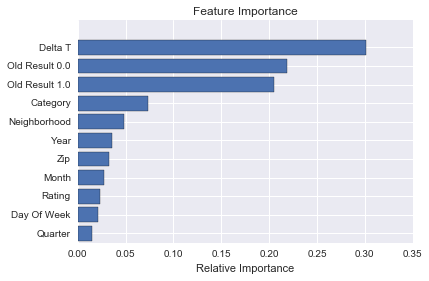

In [114]:
feature_importance = clf.feature_importances_[0:9]
feature_importance = np.append(feature_importance, sum(clf.feature_importances_[9:35]))
feature_importance = np.append(feature_importance, sum(clf.feature_importances_[35:]))
features_short=features[0:9]
features_short.append('Neighborhood')
features_short.append('Category')
features_short = [str.join(' ', x.split('_')).title() for x in features_short]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
labels = [features_short[x] for x in sorted_idx]
plt.yticks(pos, labels)
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.savefig('yelp_importance.pdf', bbox_inches='tight')

,BusinessName,Address,Date,ViolLevel,RESULT,1.0,2.0,3.0,ID,Delta_t,Zip,Result_last,Date_last,Day_of_week,Month,Year,Quarter,Old_Result_0.0,Old_Result_1.0
55459,TACO MEX,65 Maverick SQ,2008-04-02 11:11:30,9,0,9,0,0,TACO MEX:65 Maverick SQ,0,02128,-1,NaT,NaN,NaN,NaN,NaN,0,0
55460,TACO MEX,65 Maverick SQ,2008-04-23 10:02:10,9,1,9,0,0,TACO MEX:65 Maverick SQ,20,02128,0,2008-04-02 11:11:30,2,4,2008,2,1,0
55461,TACO MEX,65 Maverick SQ,2009-01-02 22:21:16,2,0,2,0,0,TACO MEX:65 Maverick SQ,254,02128,1,2008-04-23 10:02:10,2,4,2008,2,0,1
55462,TACO MEX,65 Maverick SQ,2009-08-25 12:26:29,23,0,12,1,3,TACO MEX:65 Maverick SQ,234,02128,0,2009-01-02 22:21:16,4,1,2009,1,1,0
55463,TACO MEX,65 Maverick SQ,2009-09-01 14:25:45,23,1,12,1,3,TACO MEX:65 Maverick SQ,7,02128,0,2009-08-25 12:26:29,1,8,2009,3,1,0
55464,TACO MEX,65 Maverick SQ,2010-03-12 12:08:09,22,0,8,1,4,TACO MEX:65 Maverick SQ,191,02128,1,2009-09-01 14:25:45,1,9,2009,3,0,1
55465,TACO MEX,65 Maverick SQ,2010-03-18 10:59:07,22,0,8,1,4,TACO MEX:65 Maverick SQ,5,02128,0,2010-03-12 12:08:09,4,3,2010,1,1,0
55466,TACO MEX,65 Maverick SQ,2010-03-25 14:43:50,4,1,1,0,1,TACO MEX:65 Maverick SQ,7,02128,0,2010-03-18 10:59:07,3,3,2010,1,1,0
55467,TACO MEX,65 Maverick SQ,2010-06-01 08:28:48,13,0,4,0,3,TACO MEX:65 Maverick SQ,67,02128,1,2010-03-25 14:43:50,3,3,2010,1,0,1
55468,TACO MEX,65 Maverick SQ,2010-06-18 11:28:50,13,1,4,0,3,TACO MEX:65 Maverick SQ,17,02128,0,2010-06-01 08:28:48,1,6,2010,2,1,0


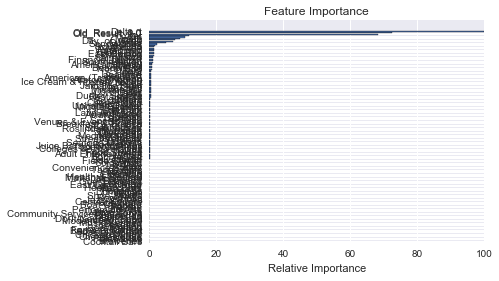

In [58]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
labels = [features[x] for x in sorted_idx]
plt.yticks(pos, labels)
plt.xlabel('Relative Importance')
plt.title('Feature Importance')

# plt.savefig('importance.pdf', bbox_inches='tight')

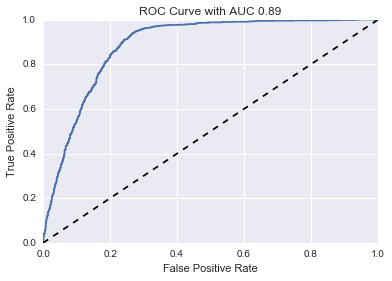

In [524]:
sns.set_style("darkgrid")
preds = clf.predict_proba(Xtest)[:,1]
fpr, tpr, _ = roc_curve(Ytest, preds)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC {0:.2f}'.format(auc(fpr, tpr)))

# plt.savefig('yelp_ROC.pdf', bbox_inches='tight')

/Users/damienrj/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


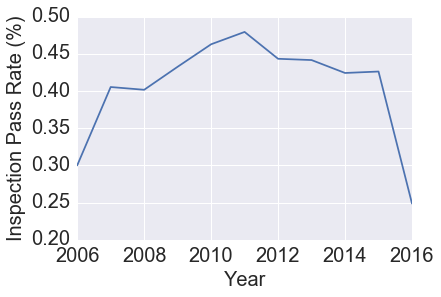

In [526]:
plot_data = clean_data.reset_index()
plot_data['Year']=plot_data.Date.dt.year
plot_data.RESULT[plot_data['RESULT'] > 0] = 1
plot_data.groupby('Year').mean().RESULT.plot(fontsize=20)
plt.ylabel("Inspection Pass Rate (%)", fontsize=20)
plt.xlabel('Year', fontsize=20)
# plt.title('Odds of inspection passing')
sns.set_style("darkgrid")
# plt.savefig('PassingRates.pdf', bbox_inches='tight')

,RESULT,Delta_t
RESULT,1.000000,-0.435822
Delta_t,-0.435822,1.000000


In [121]:
preds.shape

(10171, 2)

In [116]:
preds

array([[ 0.91385279,  0.08614721],
       [ 0.07507819,  0.92492181],
       [ 0.99431768,  0.00568232],
       ..., 
       [ 0.99804679,  0.00195321],
       [ 0.81262127,  0.18737873],
       [ 0.97826566,  0.02173434]])

In [ ]:
clf2 = joblib.load('week2.pkl') 

In [ ]:
clf2.predict(np.array([237, 0, 4, 2014, 2, '02108', 1.0, 0.0]))

In [ ]:
temp = clean_data.groupby(level=0).sum().sort_values(3, ascending=False)
temp.rename(columns={1: '*', 2: '**', 3:'***'}, inplace=True)

ax = temp[['*', '**', '***']][:10].plot(kind = 'bar')
plt.gcf().subplots_adjust(bottom=0.55)
ax.set_ylabel('# Violations')
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.savefig('sample.pdf')

## Move data to remote host

In [27]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

engine = create_engine('postgres://remote@localhost:63333/data')
print engine.url

con = None
con = psycopg2.connect(database = 'data', user = 'remote', port=63333, host='localhost')

# create_database(engine.url)

postgres://remote@localhost:63333/data


OperationalError: could not connect to server: Connection refused
	Is the server running on host "localhost" (::1) and accepting
	TCP/IP connections on port 63333?
could not connect to server: Connection refused
	Is the server running on host "localhost" (127.0.0.1) and accepting
	TCP/IP connections on port 63333?


In [23]:
g3 = long_clean.groupby('ID')
server_data = g3.last()
server_data.columns = [str(x).lower() for x in server_data.columns]


In [28]:
g3 = yelp_clean.groupby('ID')
server_data = g3.last()
server_data.columns = [str(x).lower() for x in server_data.columns]
features_low = [str(x).lower() for x in features]

In [29]:
selected_server_data[(selected_server_data.pass_odds> .30 ) & (selected_server_data.pass_odds < .70)]

NameError: name 'selected_server_data' is not defined

This section changes the delta t to the time since the last inspection. It also updates the last results to the last inspection and updates the time, and result columns. 

In [30]:
server_data['delta_t']=pd.to_datetime('2016-01-12')- server_data.date
server_data['delta_t']= (server_data['delta_t']/np.timedelta64(1,'D')).astype(int)
server_data['day_of_week']=server_data.date.dt.dayofweek
server_data['month']=server_data.date.dt.month
server_data['quarter']=server_data.date.dt.quarter
server_data['year']=server_data.date.dt.year

In [31]:
temp = pd.get_dummies(server_data['result'])
server_data['old_result_0.0']=temp[0]
server_data['old_result_1.0']=temp[1]

In [32]:
# features_low = ['delta_t', 'day_of_week', 'month', 'year', 'quarter', 'zip', 'old_result_0.0', 'old_result_1.0']
features_low
server_data['pass']=clf.predict(server_data[features_low])
odds = clf.predict_proba(server_data[features_low])
server_data['pass_odds'] = odds[:, 0]
server_data['fail_odds'] = odds[:, 1]
server_data.businessname = server_data.businessname.str.lower()


In [34]:
selected_server_data= server_data[['businessname', 'address', 'delta_t', 'date', 'pass_odds', 'fail_odds', 'type', 'neighborhoods']]
selected_server_data = selected_server_data[server_data.is_closed == False]
selected_server_data.reset_index(inplace=True)


In [35]:
selected_server_data.ID = selected_server_data.ID.str.replace("[ ]+", ' ')
selected_server_data.ID = selected_server_data.ID.str.title()

In [49]:
set(selected_server_data.neighborhoods)

{u'Allston/Brighton',
 u'Back Bay',
 u'Beacon Hill',
 u'Central Square',
 u'Charlestown',
 u'Chinatown',
 u'Dorchester',
 u'Downtown',
 u'Dudley Square',
 u'East Boston',
 u'East Cambridge',
 u'Fenway',
 u'Fields Corner',
 u'Financial District',
 u'Hyde Park',
 u'Jamaica Plain',
 u'Mattapan',
 u'Mattapan Square',
 u'Mission Hill',
 u'North End',
 u'Roslindale',
 u'Roslindale Village',
 u'South Boston',
 u'South End',
 u'Uphams Corner',
 u'Waterfront',
 u'West Roxbury'}

In [583]:
%%time
selected_server_data.to_sql('yelp', con=engine)

CPU times: user 138 ms, sys: 75 ms, total: 213 ms
Wall time: 6.24 s


In [578]:
selected_server_data.head()

,ID,businessname,address,delta_t,date,pass_odds,fail_odds,type,neighborhoods
0,224 BOSTON STREET:224 Boston ST,224 boston street,224 Boston ST,363,2015-01-13 14:32:59,0.970163,0.029837,American (New),Dorchester
1,49 Social:49 Temple PL,49 social,49 Temple PL,73,2015-10-30 12:13:33,0.917464,0.082536,American (New),Downtown
2,5 Napkin Burger:101 Huntington AV,5 napkin burger,101 Huntington AV,83,2015-10-20 12:15:04,0.916760,0.083240,Burgers,Back Bay
3,7 Pond Coffee Bar:597 Centre ST,7 pond coffee bar,597 Centre ST,0,2016-01-11 10:49:09,0.405226,0.594774,Coffee & Tea,Jamaica Plain
4,75 CHESTNUT:75 Chestnut ST,75 chestnut,75 Chestnut ST,230,2015-05-26 12:32:40,0.665235,0.334765,American (New),Beacon Hill


In [584]:
selected_server_data.ID.values[:-1]

array(['224 Boston Street:224 Boston St', '49 Social:49 Temple Pl',
       '5 Napkin Burger:101 Huntington Av',
       '7 Pond Coffee Bar:597 Centre St', '75 Chestnut:75 Chestnut St',
       '75 On Liberty Wharf:220 Northern Av',
       '973 Commonwealth:971 Commonwealth Av',
       "Alex'S Pizza:580 Dorchester Av",
       "Alfredo'S Italian Kitchen:243 Dorchester St",
       "Alfredo'S:229 Brighton Av",
       'Algonquin Club Of Boston:217 Commonwealth Av',
       'Ames Plow Tavern:200 Faneuil Hall Market Pl',
       "Amrhein'S:80 W Broadway", 'An Tain:31 India St',
       "Andre'S Cafe:811 Harrison Av",
       'Andrew Square House Of Pizza:395 Dorchester St',
       "Anthony'S Cafe:252 Commercial St", 'Antico Forno:93 Salem St',
       'Aquitaine:569 Tremont St', "Archie'S New York Deli:93 Arch St",
       'Artu:6 Prince', 'Artu:89 Charles St',
       'Atlantic Fish Company:761 Boylston St',
       'Addis Red Sea:540 Tremont St', "Amelia'S Taqueria:180 Brighton Av",
       "Amelia'S 

In [553]:
server_data.sort_values('pass_odds')[['businessname', 'address', 'delta_t', 'date', 'pass_odds']][:5].set_index('businessname')

,address,delta_t,date,pass_odds
businessname,,,,
the maiden,28 W Broadway,24,2015-12-18 11:35:54,0.235421
anthony's cafe,252 Commercial ST,21,2015-12-21 12:30:56,0.261955
taco mex,65 Maverick SQ,5,2016-01-06 12:58:13,0.265125
hilton boston logan airport,85 TERMINAL,21,2015-12-21 10:28:01,0.270181
sportello,348 Congress ST,19,2015-12-23 10:29:59,0.289799


In [34]:
test=pd.read_sql_query("SELECT * FROM recent WHERE businessname = $$auntie anne's (no. ma 110)$$", engine)

In [488]:
selected_server_data.sort_values('pass_odds')

,ID,businessname,address,delta_t,date,pass_odds,fail_odds,type,neighborhoods
855,The Maiden:28 W Broadway,the maiden,28 W Broadway,24,2015-12-18 11:35:54,0.248881,0.751119,Wine Bars,South Boston
408,Hilton Boston Logan Airport:85 Terminal,hilton boston logan airport,85 TERMINAL,21,2015-12-21 10:28:01,0.256971,0.743029,Hotels,East Boston
189,Carrie Nation:11 Beacon St,carrie nation,11 Beacon ST,5,2016-01-06 12:28:33,0.264325,0.735675,American (Traditional),Downtown
804,Taco Mex:65 Maverick Sq,taco mex,65 Maverick SQ,5,2016-01-06 12:58:13,0.279219,0.720781,Mexican,East Boston
746,Sportello:348 Congress St,sportello,348 Congress ST,19,2015-12-23 10:29:59,0.284121,0.715879,Italian,Waterfront
16,Anthony'S Cafe:252 Commercial St,anthony's cafe,252 Commercial ST,21,2015-12-21 12:30:56,0.291207,0.708793,Italian,North End
895,Uno Due Go:52 Summer St,uno due go,52 Summer ST,24,2015-12-18 11:01:35,0.308036,0.691964,American (New),Downtown
925,Zo:3 Center Plaza,zo,3 CENTER PLAZA,0,2016-01-12 10:23:49,0.315456,0.684544,Greek,Downtown
43,Barry'S Bootcamp:38 Chauncy St,barry's bootcamp,38 Chauncy ST,20,2015-12-22 15:25:10,0.324851,0.675149,Boot Camps,Downtown
631,Pollo Campero:188 Border St,pollo campero,188 Border ST,3,2016-01-08 13:57:51,0.329166,0.670834,Latin American,East Boston


In [544]:
selected_server_data['businessname'][:-1].values

array(['224 boston street', '49 social', '5 napkin burger',
       '7 pond coffee bar', '75 chestnut', '75 on liberty wharf',
       '973 commonwealth', "alex's pizza", "alfredo's italian kitchen",
       "alfredo's", 'algonquin club of boston', 'ames plow tavern',
       "amrhein's", 'an tain', "andre's cafe",
       'andrew square house of pizza', "anthony's cafe", 'antico forno',
       'aquitaine', "archie's new york deli", 'artu', 'artu',
       'atlantic fish company', 'addis red sea', "amelia's taqueria",
       "amelia's taqueria", 'americano espresso bar', 'amorino',
       "andre's cafe", "andre's cafe", "angela's cafe", "anna's taqueria",
       "anthony's pier 4", "antonio's pizzeria", 'appleton bakery cafe',
       'appleton cafe', "archie's place", 'aria trattoria',
       'ashburton cafe', 'asian too express', 'asta',
       'atlantic beer garden', 'azama grill', "barry's bootcamp",
       'bella luna restaurant', "benny's crepe cafe", 'berkeley perk cafe',
       'bfres

In [38]:
pd.read_sql("SELECT * FROM recent WHERE businessname = $${}$$".format(temp), engine)

,ID,businessname,address,date,viollevel,result,1.0,2.0,3.0,delta_t,...,date_last,day_of_week,month,year,quarter,old_result_0.0,old_result_1.0,pass,pass_odds,fail_odds
0,AUNTIE ANNE'S (No. MA 110):700 Atlantic AV,auntie anne's (no. ma 110),700 Atlantic AV,2015-03-25 14:27:37,17,1,8,0,3,292,...,2015-03-11 12:58:49,2,3,2015,1,0,1,0,0.984166,0.015834


In [ ]:
query = "SELECT * FROM recent WHERE businessname = '{}'".format('129 Lake Street Cafe')
result = pd.read_sql_query(query, engine)
result.fail_odds_odds[0]


In [57]:
import urlparse
urlparse.uses_query('aramark+%40+sullivan+%26+worcester')

TypeError: 'list' object is not callable